#**1. Entorno LunarLander**

In [1]:
!pip install box2d-py

In [2]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

env = gym.make('LunarLander-v2')

In [3]:
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space.shape))
print("Reward range is {} ".format(env.reward_range))
print("Maximum number of episodes by step is {}".format(env.spec.max_episode_steps))
print("Reward threshold is {}".format(env.spec.reward_threshold))

Action space is Discrete(4) 
Observation space is (8,) 
Reward range is (-inf, inf) 
Maximum number of episodes by step is 1000
Reward threshold is 200


In [4]:
#Visualizamos el entorno
for i_episode in range(10):
    obs = env.reset()
    for t in range(100):
        print(obs)
        action = env.action_space.sample() #Tomamos una acción
        obs, reward, done, info = env.step(action) #ejecución de la acción elegida
        if done:
            print("Episode finished after {} timesteps".format(t+1)) 
            break


[ 0.00191917  1.4214678   0.19437683  0.4687876  -0.00221707 -0.04402925
  0.          0.        ]
[ 0.00374327  1.4314477   0.18218192  0.44355115 -0.00199912  0.00435985
  0.          0.        ]
[ 0.00542049  1.4416403   0.16823104  0.45300016 -0.00249118 -0.00984221
  0.          0.        ]
[ 0.00715046  1.4519492   0.17324512  0.4581798  -0.00273535 -0.00488413
  0.          0.        ]
[ 0.00888042  1.4616581   0.17324564  0.43150875 -0.00297995 -0.00489257
  0.          0.        ]
[ 1.0529804e-02  1.4707788e+00  1.6312768e-01  4.0536001e-01
 -1.1949353e-03  3.5703514e-02  0.0000000e+00  0.0000000e+00]
[1.2236786e-02 1.4802310e+00 1.6862157e-01 4.2009878e-01 8.6113886e-04
 4.1125428e-02 0.0000000e+00 0.0000000e+00]
[0.01385097 1.4890826  0.15697016 0.39339745 0.00525192 0.08782382
 0.         0.        ]
[0.01539345 1.497345   0.14799285 0.36717695 0.01143721 0.12371721
 0.         0.        ]
[0.0170229  1.5050205  0.1589149  0.34110165 0.01542566 0.0797763
 0.         0.     

# **2. Construcción del algoritmo de REINFORCE con línea de base**

In [5]:
class PGReinforce(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(PGReinforce, self).__init__()
        self.device=device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.learning_rate = learning_rate
        
        ### Construcción de la red neuronal
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs,16),
            torch.nn.Tanh(),
            torch.nn.Linear(16,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, self.n_outputs),
            torch.nn.Softmax(dim=-1))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        
        ### Se ofrece la opción de trabajar con cuda
        if self.device == 'cuda':
            self.model.cuda()

    #Obtención de las probabilidades de las posibles acciones       
    def get_action_prob(self, state):
        action_probs = self.model(torch.FloatTensor(state))
        return action_probs

In [6]:
class reinforceAgent:    
   

    def __init__(self, env, dnnetwork):        
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        
        self.env = env
        self.dnnetwork = dnnetwork
        self.nblock = 100
        self.reward_threshold = self.env.spec.reward_threshold
        
        self.initialize()
        

    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_loss = []
        self.print_loss = []
        
    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size
        
        episode = 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            state0 = env.reset()
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False
            
            while gamedone == False:

                action_probs = self.dnnetwork.get_action_prob(state0).detach().numpy()  #distribución de probabilidad de las acciones dado el estado actual
                action = np.random.choice(action_space, p=action_probs)   #acción aleatoria de la distribución de probabilidad
                next_state, reward, gamedone, _ = env.step(action)

                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
               
                state0 = next_state
                
                
                if gamedone:
                    episode += 1
                    # Calculamos el término del retorno menos la línea de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.batch_counter += 1
                    self.training_rewards.append(sum(episode_rewards))
                    
                    
                    # Actualizamos la red cuando se completa el tamaño del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)
                        self.update_loss = []
                    
                        # Reseteamos las variables del epsiodio
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1
                    
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
               
                    print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(
                        episode, mean_rewards), end="")
                    
                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                        
                        
    
    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = discount_r - discount_r.mean()
        return baseline
    ########
    
    
    
    #Actualización                
    def update(self, batch_s, batch_r, batch_a):
        self.dnnetwork.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)       
        action_t = torch.LongTensor(batch_a)             
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.dnnetwork.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())
            
        

    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.dnnetwork.get_action_prob(state_t))
        selected_logprobs = reward_t * \
                        logprob[np.arange(len(action_t)), action_t]
        loss = -selected_logprobs.mean()
        self.print_loss.append(loss)
        return loss
    
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()
     #######

In [7]:
lr = 0.005      #Velocidad aprendizaje
max_episodes = 5000  #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
gamma = 0.99
batch_size = 8

In [8]:
pgR = PGReinforce(env, learning_rate=lr)

In [9]:
agent = reinforceAgent(env, pgR)

In [10]:
agent.train(gamma=gamma, max_episodes=max_episodes, batch_size=batch_size)

Training...
Episode 1765 Mean Rewards 200.23		
Environment solved in 1765 episodes!


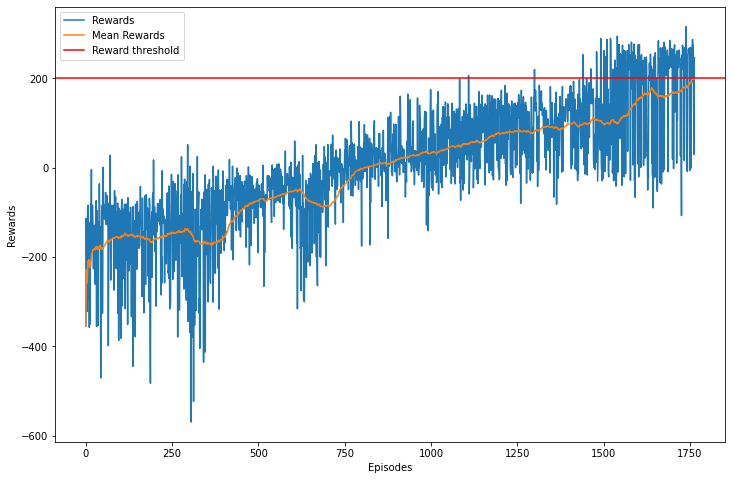

In [11]:
agent.plot_rewards()